# Notebook for Phenol Red Assay pH Measurement

### Equation
$$
pH = a + b \cdot \ln(A_{560})
$$
* Where A_{560} is the Absorbance at 560 nm, measured using the Tecan Spark  
* $ a$ and $ b$ are fit with data from the standards using the code below
* Sample pH is calculated using the fitted equation

### Importing Dataframes

In [12]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Fitting Standards

Loading Data

In [ ]:
# Load plate dataframe
df = pd.read_csv('mock_data.csv', index_col=0)

# Standard values and positions
std_ph = [6.0, 6.5, 7.0, 7.5]  # Fill pH values
std_pos = ['A1', 'B2', 'D3', 'C3']  # Corresponding well positions

Parsing and Running Checks

In [10]:
a_to_h = list('ABCDEFGH')

a560_values = []

assert len(std_ph) == len(std_pos), "Enter equal pH values and well positions"

for pos in std_pos:
    match = re.fullmatch(r'([A-H])(\d{1,2})', pos)
    if not match:
        raise ValueError(f"Invalid position format or out of bounds: {pos}")
    
    row, col = match.groups()
    col = int(col)
    
    if col < 1 or col > 12:
        raise ValueError(f"Column out of range in position: {pos}")
    
    try:
        a560 = df.loc[row, str(col)]
        a560_values.append(a560)
    except KeyError:
        raise ValueError(f"Invalid position in data: {pos}")

Fitting Equation

In [11]:
a560_values = np.array(a560_values)
ln_a560 = np.log(a560_values)
std_ph = np.array(std_ph)

# Fit model: pH = a + b * ln(A560)
def model(x, a, b):
    return a + b * x

params, _ = curve_fit(model, ln_a560, std_ph)
a_fit, b_fit = params

print(f"Fitted equation: pH = {a_fit:.4f} + {b_fit:.4f} * ln(A560)")

Fitted equation: pH = 10.0709 + 2.9300 * ln(A560)


Plotting the Fit

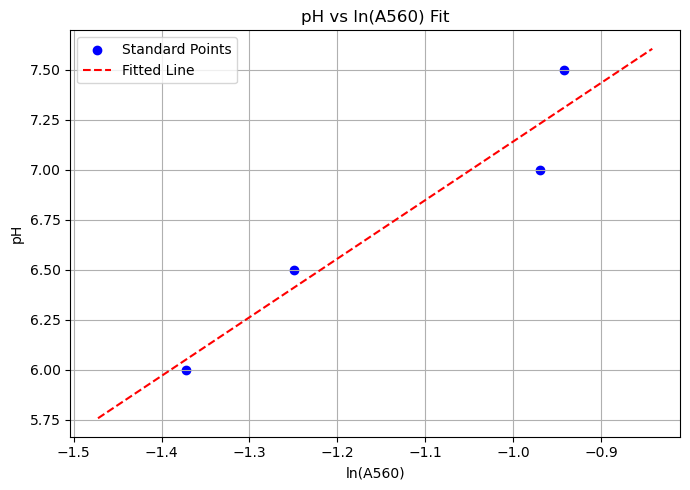

In [ ]:
# Plot
x_vals = np.linspace(ln_a560.min() - 0.1, ln_a560.max() + 0.1, 100)
y_vals = model(x_vals, *params)

plt.figure(figsize=(7, 5))
plt.scatter(ln_a560, std_ph, color='blue', label='Standard Points')
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Fitted Line')
plt.xlabel('ln(A560)')
plt.ylabel('pH')
plt.title('pH vs ln(A560) Fit for Standards')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Calculating pH for Samples

In [15]:
def convert_a560_to_ph(df_a560, a, b):
    """
    Convert a DataFrame of A560 values to pH using the formula: pH = a + b * ln(A560)
    
    Parameters:
        df_a560 (pd.DataFrame): DataFrame with A560 values (indexed by A-H, columns 1-12 as strings)
        a (float): Intercept from the fitted model
        b (float): Slope from the fitted model
        
    Returns:
        pd.DataFrame: New DataFrame with pH values
    """
    # Avoid log(0) or negative values
    if (df_a560 <= 0).any().any():
        raise ValueError("All A560 values must be positive to compute logarithm.")
    
    df_ln_a560 = np.log(df_a560)
    df_ph = a + b * df_ln_a560
    return df_ph

In [ ]:
df_ph = convert_a560_to_ph(df, a_fit, b_fit)

# Save Output
df_ph.to_csv('pH_test_output.csv') 